## Fit Guinier 

In [1]:
import pandas as pd
import os
import sys,math

from scipy import optimize
from scipy import special
from scipy.optimize import curve_fit
from scipy import stats 

import numpy as np
import glob

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from collections import OrderedDict
from collections import defaultdict

import re

import seaborn as sns
import pickle


In [2]:
# Class to Read Data

class DataProcessor:
    def __init__(self, base_dir, save_dir):
        self.base_dir = base_dir
        self.save_dir = save_dir  # Directory to save the processed files
        self.dataframes = []

    def extract_last_number(self, file_name):
        match = re.search(r'(\d+)(?!.*\d)', file_name)
        return match.group(1) if match else None

    def get_concentration(self, file_name):
        if '0_5mg_mL' in file_name:
            return '0.5mg/mL'
        elif '1_5mg_mL' in file_name:
            return '1.5mg/mL'
        elif '1mg_mL' in file_name:
            return '1.0mg/mL'
        elif '2mg_mL' in file_name:
            return '2.0mg/mL'
        elif '3mg_mL' in file_name:
            return '3.0mg/mL'
        elif '3mg_ml' in file_name:
            return '1.7mg/mL'
        elif '4mg_ml' in file_name:
            return '2.3mg/mL'
        elif '5mg_ml' in file_name:
            return '2.8mg/mL'
        return 'unknown'

    def get_addition(self, file_name):
        if 'EPI' in file_name:
            return 'EPI-001'
        elif 'DMSO' in file_name or 'dmso' in file_name:
            return 'DMSO'
        return 'buffer'

    def sanitize_file_name(self, file_name):
        sanitized_name = re.sub(r'[\/:*?"<>|]', '_', file_name)
        sanitized_name = sanitized_name.replace(' ', '_')
        return sanitized_name[:255]

    def save_dataframe(self, df, file_name):
        # Construct the full save path
        save_file_name = f"{file_name}_Processed.csv"
        save_path = os.path.join(self.save_dir, save_file_name)
        # Save the DataFrame as a CSV
        df.to_csv(save_path, index=False)
        # print(f"Saved DataFrame to {save_path}")

    def process_file(self, file_path, save=False):
            file_name = os.path.basename(file_path)

            # Read the data
            df = pd.read_csv(file_path, delim_whitespace=True, header=None, comment='#')
            df = df.rename(columns={0: 'q', 1: 'I(q)', 2: 'Error'})

            # Extract the last number from the file name
            last_number = self.extract_last_number(file_name)

            # Determine custom_name based on the file name prefix
            if file_name.startswith('aa'):
                custom_name = 'W397A/W433A'
            elif file_name.startswith('WT'):
                custom_name = 'WT'
            else:
                custom_name = 'unknown'

            # Determine concentration and addition
            concentration = self.get_concentration(file_name)
            addition = self.get_addition(file_name)

            # Create save file name
            save_file_name = f"{custom_name}_{concentration}_{addition}_{last_number}"
            sanitized_save_file_name = self.sanitize_file_name(save_file_name)

            # Create legend name and commonality
            legend_name = f"{custom_name}_{concentration}_{addition}"
            common_name = f"{custom_name}, {concentration}, +{addition}"

            # Attach attributes to the DataFrame
            df.attrs['file_name'] = file_name
            df.attrs['repetition'] = last_number
            df.attrs['custom_name'] = custom_name
            df.attrs['concentration'] = concentration
            df.attrs['addition'] = addition
            df.attrs['save_file_name'] = sanitized_save_file_name
            df.attrs['legend_name'] = legend_name
            df.attrs['commonality'] = common_name

            # Conditionally save the DataFrame only if the `save` flag is True
            if save:
                self.save_dataframe(df, sanitized_save_file_name)

            # Store DataFrame in list for later processing
            self.dataframes.append(df)

    def process_files(self, file_name=None, save=False):
        if file_name:
            file_path = os.path.join(self.base_dir, file_name)
            self.process_file(file_path, save)
        else:
            for file_name in os.listdir(self.base_dir):
                if file_name.endswith('.dat'):
                    file_path = os.path.join(self.base_dir, file_name)
                    self.process_file(file_path, save)

    def get_dataframes(self):
        return self.dataframes


In [3]:
# Example usage
base_dir = '/Users/natalieloui/Library/CloudStorage/OneDrive-DartmouthCollege/Robustelli Laboratory/SAXS Results/Raw Data/_s data/08062024/'
save_dir = '/Users/natalieloui/Library/CloudStorage/OneDrive-DartmouthCollege/Robustelli Laboratory/SAXS Results/Raw Data/_s data/08062024/Processed AA/'
processor = DataProcessor(base_dir, save_dir)
# Call process_files without saving by passing save=False
selected_file = 'aa_1mg_mL_1_s.dat'
processor.process_files(file_name=selected_file, save=False)
# Access processed DataFrames
dataframes = processor.get_dataframes()

ex_df=dataframes[0]
print(f"Attributes for {ex_df.attrs['file_name']}:")
print(f"Repetition: {ex_df.attrs['repetition']}, Custom Name: {ex_df.attrs['custom_name']}, Commonality: {ex_df.attrs['commonality']}")
print(ex_df)

Attributes for aa_1mg_mL_1_s.dat:
Repetition: 1, Custom Name: W397A/W433A, Commonality: W397A/W433A, 1.0mg/mL, +buffer
         q      I(q)     Error
0    0.005  0.480000  1.885000
1    0.006  0.604900  0.691200
2    0.007  0.390900  0.422300
3    0.008  0.743000  0.268900
4    0.009  0.589400  0.188700
..     ...       ...       ...
269  3.070  0.004142  0.005103
270  3.100  0.003332  0.006875
271  3.130  0.003510  0.008460
272  3.160  0.002587  0.009047
273  3.190  0.003249  0.010070

[274 rows x 3 columns]


In [8]:
def Guinier(df, Nres, b_Angstrom, nu_init, Rg_input, q_start_index=0):
    def Rg_nu(b, N, nu):
        g = 1.1615
        return (g * (g + 1) / (2 * (g + 2 * nu) * (g + 2 * nu + 1))) ** 0.5 * b * N ** nu

    def chisq_extguin(parms, q, log_Iq, Nres, b):
        nu = parms[0]
        log_I0 = parms[1]
        Rg = Rg_nu(b, Nres, nu)

        log_Iq_fit = log_I0 - 1 / 3 * q ** 2 * Rg ** 2 + 0.0479 * (nu - 0.212) * q ** 4 * Rg ** 4
        dI = log_Iq_fit - log_Iq
        return np.dot(dI, dI)

    if q_start_index >= len(df):
        return None

    q = df['q'].values
    Iq = df['I(q)'].values
    Rg_init = Rg_nu(b_Angstrom, Nres, 0.6)
    print(f"Rg calculated initial is {Rg_init}")
    
    
    
    qcut = 1.3 / Rg_input
    q_lt_cut = q < qcut
    qrange = q[q_lt_cut]
    log_Iq = np.log(Iq[q_lt_cut])

    log_I0_init = log_Iq[0]
    init_parm = [nu_init, log_I0_init]

    opt_parm = optimize.fmin(chisq_extguin, init_parm, args=(qrange, log_Iq, Nres, b_Angstrom), disp=True)
    nu_final, log_I0_final = opt_parm
    Rg_final = Rg_nu(b_Angstrom, Nres, nu_final)

    log_Iq_fit = log_I0_final - 1 / 3 * qrange ** 2 * Rg_final ** 2 + 0.0479 * (nu_final - 0.212) * qrange ** 4 * Rg_final ** 4

    df_cut = df[q_lt_cut].copy()
    df_cut['Guinier_q_squared'] = qrange ** 2
    df_cut['Guinier_log_Iq'] = log_Iq
    df_cut['Guinier_log_Iq_fit'] = log_Iq_fit

    return df_cut, Rg_final, nu_final


In [9]:
Nres=121
b_Angstrom=5.5
nu_init=0.5
Rg_input=31

df_cut, Rg_final, nu_final =Guinier(ex_df, Nres, b_Angstrom, nu_init, Rg_input, q_start_index=0)

print(f"Rg expected is {Rg_input} A^-1. Rg_final calculated by Extended Guinier is {Rg_final} A^-1.")
df_cut

Rg calculated initial is 38.86383092615495
Optimization terminated successfully.
         Current function value: 0.392696
         Iterations: 28
         Function evaluations: 56
Rg expected is 31 A^-1. Rg_final calculated by Extended Guinier is 26.43419745525865 A^-1.


,q,I(q),Error,Guinier_q_squared,Guinier_log_Iq,Guinier_log_Iq_fit
0,0.005,0.4800,1.88500,0.000025,-0.733969,-0.508890
1,0.006,0.6049,0.69120,0.000036,-0.502692,-0.511448
2,0.007,0.3909,0.42230,0.000049,-0.939304,-0.514468
3,0.008,0.7430,0.26890,0.000064,-0.297059,-0.517950
4,0.009,0.5894,0.18870,0.000081,-0.528650,-0.521893
5,0.010,0.6431,0.15900,0.000100,-0.441455,-0.526295
6,0.011,0.7050,0.12110,0.000121,-0.349557,-0.531155
7,0.012,0.5370,0.08909,0.000144,-0.621757,-0.536470
8,0.013,0.5722,0.07100,0.000169,-0.558267,-0.542240
9,0.014,0.5434,0.05941,0.000196,-0.609910,-0.548461


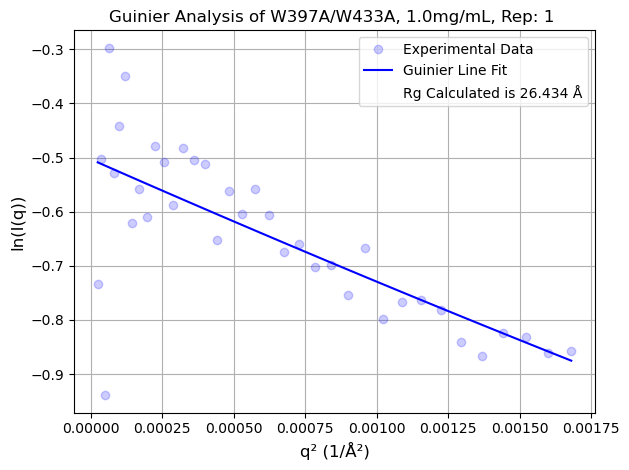

In [15]:
ex_df=df_cut
Rg_final_short=round(Rg_final, 3)

plt.plot(figsize=(12,6))
title_name=(f"{ex_df.attrs['custom_name']}, {ex_df.attrs['concentration']}, Rep: {ex_df.attrs['repetition']} ")


plt.plot(ex_df['Guinier_q_squared'], ex_df['Guinier_log_Iq'], marker='o',linestyle='None', alpha=0.2,label='Experimental Data', color='b')
plt.plot(ex_df['Guinier_q_squared'], ex_df['Guinier_log_Iq_fit'], linestyle='-', color='b', label='Guinier Line Fit')
plt.xlabel('q² (1/Å²)', fontsize=12)
plt.ylabel('ln(I(q))', fontsize=12)

Rg_value = Line2D([0], [0], color='w', label=f'Rg Calculated is {Rg_final_short} Å', linestyle='None')
plt.legend(handles=plt.gca().get_legend_handles_labels()[0]+ [Rg_value])


plt.title(f"Guinier Analysis of {title_name}")

plt.grid(True)


# Adjust layout and display the plots
plt.tight_layout()
plt.show()